# Climatology generator prototype

#### Date: 4 December, 2023

Author = {"name": "Thomas Moore", "affiliation": "CSIRO", "email": "thomas.moore@csiro.au", "orcid": "0000-0003-3930-1946"}

### BRAN2020 is 16TB of data over nearly 9000 `netcdf` file assests in total.
### But our ARD workflow makes the efficient `zarr` collections for this notebook

# Setup

#### required packages

In [1]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
#more plotting
import matplotlib.dates as mdates
import seaborn as sns

#### start a local Dask client

In [2]:
from dask.distributed import Client
#client = Client(threads_per_worker=1)
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45463,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:40213,Total threads: 4
Dashboard: /proxy/44965/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:39413,


#### ignore warnings

In [3]:
import warnings
warnings.filterwarnings('ignore')

## basic functions

In [33]:
def get_monthly_climatology(xr_object,time_coord_name = 'time',flox=True):
    if flox == True:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True,method="cohorts", engine="flox")
    else:
        monthly_climatology = xr_object.groupby(time_coord_name+'.month').mean(dim=time_coord_name,keep_attrs = True)
    return monthly_climatology

def get_monthly_anomaly(xr_object,monthly_climatology, time_coord_name = 'time'):
    monthly_anomaly = xr_object.groupby(time_coord_name+'.month') - monthly_climatology
    return monthly_anomaly

# post-processing workflow $\Downarrow$

## load in both zarr collections

In [4]:
BRAN2020_ard_path = '/scratch/es60/ard/reanalysis/BRAN2020/'
ard_file_ID = 'BRAN2020-monthly-temp-v13112023.zarr'
ard_rcTime_file_ID = 'BRAN2020-monthly-temp-chunk4time-v13112023.zarr'

In [5]:
temp_chunked_time = xr.open_zarr(BRAN2020_ard_path + ard_rcTime_file_ID,consolidated=True)
temp_chunked = xr.open_zarr(BRAN2020_ard_path + ard_file_ID,consolidated=True)

## define El Nino and La Nina using NCAR ONI data

In [11]:
ONI_DF = pd.read_csv('/g/data/xv83/users/tm4888/data/ENSO/NCAR_ONI.csv')
ONI_DF.set_index('datetime',inplace=True)
ONI_DF.index = pd.to_datetime(ONI_DF.index)
el_nino_threshold = 0.5
la_nina_threshold = -0.5
el_nino_threshold_months = ONI_DF["ONI"].ge(el_nino_threshold)
la_nina_threshold_months = ONI_DF["ONI"].le(la_nina_threshold) 
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.rename('El Nino threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.rename('La Nina threshold')], axis=1)
ONI_DF = pd.concat([ONI_DF, el_nino_threshold_months.diff().ne(0).cumsum().rename('El Nino event group ID')], axis=1)
ONI_DF = pd.concat([ONI_DF, la_nina_threshold_months.diff().ne(0).cumsum().rename('La Nina event group ID')], axis=1)

In [12]:
El_Nino_Series = ONI_DF.groupby('El Nino event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['El Nino threshold'] == True)
ONI_DF = pd.concat([ONI_DF, El_Nino_Series.rename('El Nino')], axis=1)
La_Nina_Series = ONI_DF.groupby('La Nina event group ID')['ONI'].filter(lambda x: len(x) >= 5,dropna=False).where(ONI_DF['La Nina threshold'] == True)
ONI_DF = pd.concat([ONI_DF, La_Nina_Series.rename('La Nina')], axis=1)

## heatmap

### make table for average over certain region

In [13]:
%%time
max_lat = 5.0
min_lat = -5.0
max_lon = 240
min_lon = 190
LatIndexer, LonIndexer = 'yt_ocean', 'xt_ocean'
SliceData = temp_anomaly.temp.isel(st_ocean=0).sel(**{LatIndexer: slice(min_lat, max_lat),
                        LonIndexer: slice(min_lon, max_lon)})
SliceData = SliceData.chunk({'Time':-1,'yt_ocean':-1,'xt_ocean':-1,})
# THIS CURRENTLY IGNORES GRID AREA CORRECTION 
spatial_mean_of_ONI_anomaly = SliceData.mean({'yt_ocean','xt_ocean'})
spatial_mean_of_ONI_anomaly = spatial_mean_of_ONI_anomaly.compute()

CPU times: user 10.4 s, sys: 1.14 s, total: 11.6 s
Wall time: 38.6 s


In [14]:
spatial_mean_of_ONI_anomaly_DF = spatial_mean_of_ONI_anomaly.to_dataframe()
spatial_mean_of_ONI_anomaly_DF['year'] = pd.DatetimeIndex(spatial_mean_of_ONI_anomaly_DF.index).year

In [15]:
heatmap_data = spatial_mean_of_ONI_anomaly_DF.pivot_table(index='month', columns='year', values='temp')

#### stacked heatmap plot

In [16]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']

In [17]:
event_data_EN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='El Nino',dropna=False).fillna('')
event_data_LN = ONI_DF_BRANtime.pivot_table(index='month', columns='year', values='La Nina',dropna=False).fillna('')

Text(0.5, 1.0, 'Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

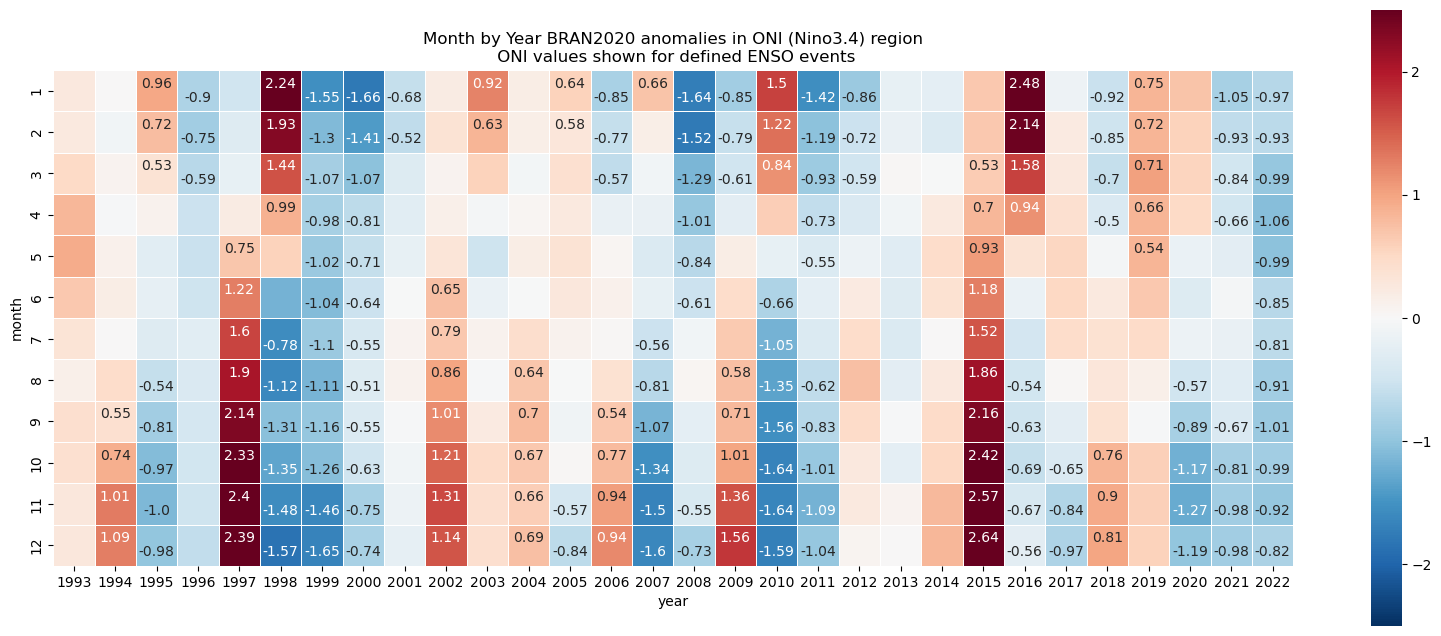

In [18]:
plt.figure(figsize=(20,8))
sns.heatmap(heatmap_data, annot=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_LN, annot_kws={'va':'top'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
sns.heatmap(heatmap_data, annot=event_data_EN, annot_kws={'va':'bottom'}, fmt="", cbar=False,cmap='RdBu_r', square=True,vmin=-2.5, vmax=2.5,linewidth=.5)
plt.title('Month by Year BRAN2020 anomalies in ONI (Nino3.4) region\n ONI values shown for defined ENSO events')

#### count of events in BRAN2020 period
El Nino = 8 events ( weak - strong ) as defined by ONI<br>
La Nina = 10 events ( weak - strong ) as defined by ONI <br>
El Nino months total = 70 = 19%
La Nina months total = 119 = 33%
Neutral months total = 171 = 48%


# filter BRAN2020 data by ENSO

In [19]:
ONI_DF_BRANtime = ONI_DF['1993-01':'2022-12']
ONI_DF_BRANtime['El Nino LOGICAL'] = ONI_DF_BRANtime['El Nino'].notnull()
ONI_DF_BRANtime['La Nina LOGICAL'] = ONI_DF_BRANtime['La Nina'].notnull()

In [20]:
El_Nino_mask = ONI_DF_BRANtime['El Nino LOGICAL']
El_Nino_mask = El_Nino_mask.to_xarray()
El_Nino_mask = El_Nino_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
El_Nino_mask['Time'] = sync_Time

In [21]:
La_Nina_mask = ONI_DF_BRANtime['La Nina LOGICAL']
La_Nina_mask = La_Nina_mask.to_xarray()
La_Nina_mask = La_Nina_mask.rename({'datetime':'Time'})
sync_Time = temp_chunked_time.Time
La_Nina_mask['Time'] = sync_Time

In [22]:
ONI_DF_BRANtime['Neutral LOGICAL'] = (ONI_DF_BRANtime['El Nino LOGICAL'] == False) & (ONI_DF_BRANtime['La Nina LOGICAL'] == False)

In [23]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum()

70

In [24]:
ONI_DF_BRANtime['La Nina LOGICAL'].sum()

119

In [25]:
ONI_DF_BRANtime['Neutral LOGICAL'].sum()

171

# Test if they add to 360

In [26]:
ONI_DF_BRANtime['El Nino LOGICAL'].sum() + ONI_DF_BRANtime['La Nina LOGICAL'].sum()+ONI_DF_BRANtime['Neutral LOGICAL'].sum() == 360

True

##  mask events in both space and time chunked versions

In [27]:
El_Nino_temp_chunked_time = temp_chunked_time.temp.where(El_Nino_mask)
La_Nina_temp_chunked_time = temp_chunked_time.temp.where(La_Nina_mask)

El_Nino_temp_chunked = temp_chunked.temp.where(El_Nino_mask)
La_Nina_temp_chunked = temp_chunked.temp.where(La_Nina_mask)

# Climatologies

In [7]:
temp_monthly_climatology = get_monthly_climatology(temp_chunked_time, time_coord_name = 'Time')
temp_monthly_climatology_rc = temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
#El Nino
El_Nino_temp_monthly_climatology = get_monthly_climatology(El_Nino_temp_chunked_time, time_coord_name = 'Time')
El_Nino_temp_monthly_climatology_rc = El_Nino_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})
#La Nina
La_Nina_temp_monthly_climatology = get_monthly_climatology(La_Nina_temp_chunked_time, time_coord_name = 'Time')
La_Nina_temp_monthly_climatology_rc = La_Nina_temp_monthly_climatology.chunk({'st_ocean':10,'xt_ocean':3600,'month':1})

<xarray.Dataset>
Dimensions:   (month: 12, st_ocean: 51, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * st_ocean  (st_ocean) float64 2.5 7.5 12.5 ... 2.895e+03 3.603e+03 4.509e+03
  * xt_ocean  (xt_ocean) float64 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    temp      (month, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(12, 1, 1500, 100), meta=np.ndarray>
Attributes: (12/13)
    NumFilesInSet:                   20
    acknowledgement:                 BRAN is made freely available by CSIRO B...
    catalogue_doi_url:               http://dx.doi.org/10.25914/6009627c7af03
    grid_tile:                       N/A
    grid_type:                       regular
    intake_esm_attrs:_data_format_:  netcdf
    ...                              ...
    intake_esm_attrs:source:         BRAN2020
    intake_esm_attrs:time_period:    month
    intake_esm_attrs:variable:       temp
    intake_esm_dataset_key:          ocean.month
    intake_esm_vars:                 ['temp']
    title:                           BRAN2020

# Anomalies

In [10]:
temp_anomaly = get_monthly_anomaly(temp_chunked,temp_monthly_climatology_rc,time_coord_name='Time')
El_Nino_temp_anomaly = get_monthly_anomaly(El_Nino_temp_chunked,El_Nino_temp_monthly_climatology_rc,time_coord_name='Time')
La_Nina_temp_anomaly = get_monthly_anomaly(La_Nina_temp_chunked,La_Nina_temp_monthly_climatology_rc,time_coord_name='Time')

# Mean, Median, Max , Min, Std, 05 & 95 quantiles

In [31]:
El_Nino_mean = El_Nino_temp.mean('Time')
El_Nino_median = El_Nino_temp.median('Time')
El_Nino_max = El_Nino_temp.max('Time')
El_Nino_min = El_Nino_temp.min('Time')
El_Nino_std = El_Nino_temp.std('Time')
El_Nino_quant = El_Nino_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [32]:
La_Nina_mean = La_Nina_temp.mean('Time')
La_Nina_median = La_Nina_temp.median('Time')
La_Nina_max = La_Nina_temp.max('Time')
La_Nina_min = La_Nina_temp.min('Time')
La_Nina_std = La_Nina_temp.std('Time')
La_Nina_quant = La_Nina_temp.quantile([0.05,0.95],skipna=True,dim='Time')

In [ ]:
mean = temp_chunked_time.mean('Time')
median = temp_chunked_time.median('Time')
max = temp_chunked_time.max('Time')
min = temp_chunked_time.min('Time')
std = temp_chunked_time.std('Time')
quant = temp_chunked_time.quantile([0.05,0.95],skipna=True,dim='Time')

# The End

In [ ]:
client.shutdown()